In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

dataDir = './archive/images'

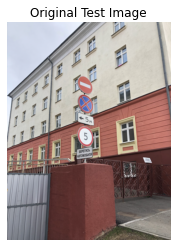

In [134]:
ogImg = cv2.imread(os.path.join(dataDir, 'road162.png'))

ogImg = cv2.cvtColor(ogImg, cv2.COLOR_BGR2RGB)

plt.imshow(ogImg)
plt.title('Original Test Image')
plt.axis('off')
plt.show()

In [140]:
finalImg = ogImg.copy()
testImg = ogImg.copy()
#testImg = cv2.medianBlur(testImg, 5)

# REMOVE SHADOWS

rgb_planes = cv2.split(testImg)
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_norm_planes.append(norm_img)

testImg = cv2.merge(result_norm_planes)

#

testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

# lower mask (0-10)
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(testImg, lower_red, upper_red)

# upper mask (170-180)
lower_red = np.array([170,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(testImg, lower_red, upper_red)

# join my masks
mask = mask0+mask1

# set my output img to zero everywhere except my mask
testImgRed = ogImg.copy()
testImgRed[np.where(mask==0)] = 0

# CLOSING

kernel = np.ones((3,3),np.uint8)
testImgRed = cv2.morphologyEx(testImgRed, cv2.MORPH_CLOSE, kernel)

# Second blur to reduce more noise, easier circle detection (IMAGE IN BGR)


testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_BGR2GRAY)

testImgRed = cv2.medianBlur(testImgRed, 9)
cv2.imshow('gray circle', testImgRed)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Use the Hough transform to detect circles in the image
circles = cv2.HoughCircles(testImgRed, cv2.HOUGH_GRADIENT, 1, testImgRed.shape[0] / 8, param1=50, param2=33, minRadius=0, maxRadius=0)
# If we have extracted a circle, draw an outline
# We only need to detect one circle here, since there will only be one reference object
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(finalImg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(finalImg,(i[0],i[1]),2,(0,0,255),3)
    
# Display the result
finalImg = cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR)
cv2.imshow('red sign', finalImg)
cv2.waitKey(0)
cv2.destroyAllWindows()